In [3]:
import fastf1
import pandas as pd
#!pip install scikit-learn-extra

SOFT = 0
MEDIUM = 1
HARD = 2
WET = -1
CLEAN = 0

In [4]:
def get_data_laps(year, event, session_name):
    session = fastf1.get_session(year, event, session_name)
    session.load()
    laps = session.laps

    laps['LapTime'] = laps['LapTime']
    laps['Sector1Time'] = laps['Sector1Time'].dt.total_seconds()
    laps['Sector2Time'] = laps['Sector2Time'].dt.total_seconds()
    laps['Sector3Time'] = laps['Sector3Time'].dt.total_seconds()
    laps['LapsInStint'] = laps.groupby(['DriverNumber', 'Stint'])['LapNumber'].transform('count')
    # Mark OutLap as the lap where PitOutTime is not null (driver just exited the pits)
    laps['OutLap'] = laps['PitOutTime'].notna()
    # Mark InLap as the lap where PitInTime is not null (driver is about to enter the pits)
    laps['InLap'] = laps['PitInTime'].notna()
    # We compute the fuel level of the number of laps left in the stint
    laps['FuelLevel'] = laps['LapsInStint'] - (laps['LapNumber'] - laps.groupby(['DriverNumber', 'Stint'])['LapNumber'].transform('min'))
    # Map compounds to numerical values, use -1 for any other/unexpected value
    return laps

def get_free_practice_data(year, event):
    sessions = ['FP1', 'FP2', 'FP3']
    all_data = []

    for session_name in sessions:
        session_data = get_data_laps(year, event, session_name)
        session_data['Session'] = session_name  # Optional: tag the session
        all_data.append(session_data)

    # Combine all sessions into one DataFrame
    return pd.concat(all_data, ignore_index=True)

In [5]:
data = get_free_practice_data(2024, 'Japan')

data_saved = data.copy()

req         WARNING 	DEFAULT CACHE ENABLED! (481.7 MB) C:\Users\marti\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Japanese Grand Prix - Practice 1 [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '40', '44', '55', '63', '77', '81']
core       

we evaluate the clustering basing on how well the cluster 0 is recognized since is the one of intrest

In [6]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist

def cluster0_quality_score(X_scaled, labels):
    # Points in cluster 0
    cluster0_points = X_scaled[labels == 0]
    # Points NOT in cluster 0 (including noise)
    other_points = X_scaled[labels != 0]

    if len(cluster0_points) < 2:
        # Not enough points in cluster 0 to evaluate compactness
        return -1

    # Intra-cluster distances within cluster 0 (pairwise distances)
    intra_dists = cdist(cluster0_points, cluster0_points, metric='chebyshev')
    # Remove diagonal zeros by taking upper triangle distances only
    intra_dists = intra_dists[np.triu_indices_from(intra_dists, k=1)]
    mean_intra = np.mean(intra_dists)

    if len(other_points) == 0:
        # No other points, so no separation possible
        # Smaller intra-cluster distance is better
        return mean_intra

    # Inter-cluster distances between cluster 0 and other points
    inter_dists = cdist(cluster0_points, other_points, metric='chebyshev')
    mean_inter = np.mean(inter_dists)

    # Score = separation / compactness (higher is better)
    score = mean_inter / (mean_intra + 1e-10)
    return score

def tune_DBSCAN(features, data):
    # Remove inlaps and outlaps, drop NaNs in selected features
    data_clean = data[~data['InLap'] & ~data['OutLap']].dropna(subset=features)
    X = data_clean[features].astype(float).values
    X_scaled = StandardScaler().fit_transform(X)

    eps_values = np.arange(0.1, 1.5, 0.1)
    min_samples_values = range(3, 10)
    results = []

    for eps, min_samples in product(eps_values, min_samples_values):
        db = DBSCAN(eps=eps, min_samples=min_samples, metric="chebyshev")
        labels = db.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Calculate the custom cluster 0 quality score
        score = cluster0_quality_score(X_scaled, labels)
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'cluster0_score': score,
            'n_clusters': n_clusters
        })

    results_df = pd.DataFrame(results)
    best = results_df.loc[results_df['cluster0_score'].idxmax()]
    print("Best Params according to cluster0 quality score:")
    print(best)
    return best

def perform_dbscan(params, data, features, column_name='Cluster'):
    data_clean = data[~data['InLap'] & ~data['OutLap']].dropna(subset=features)
    best_eps = params['eps']
    best_min_samples = int(params['min_samples'])
    X = data_clean[features].astype(float).values
    X_scaled = StandardScaler().fit_transform(X)

    # Run DBSCAN with the best found parameters
    dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric="chebyshev")
    clusters = dbscan_best.fit_predict(X_scaled)

    # Assign cluster labels back to the clean subset in original data
    data.loc[data_clean.index, column_name] = clusters

    return data


features = ['Sector1Time', 'Sector2Time', 'Sector3Time']
best_params = tune_DBSCAN(features, data)
data_with_clusters = perform_dbscan(best_params, data, features, 'Cluster')


Best Params according to cluster0 quality score:
eps                0.100000
min_samples        4.000000
cluster0_score    13.096462
n_clusters         1.000000
Name: 1, dtype: float64


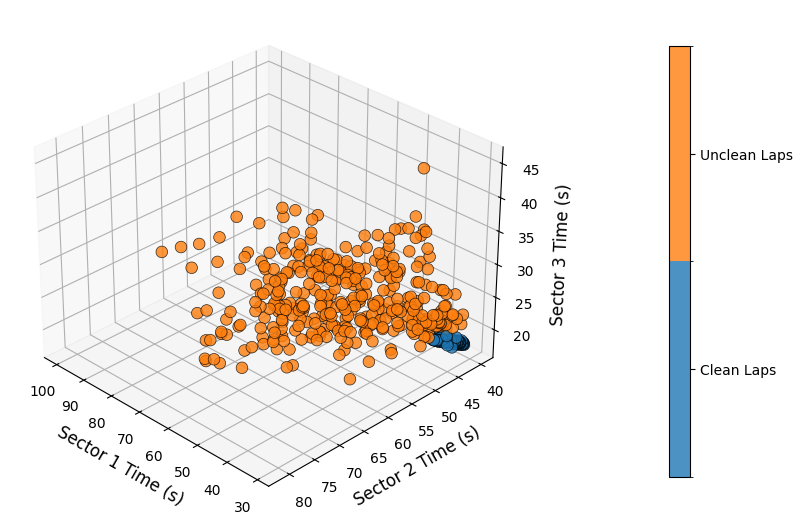

In [7]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np

def print_graph(data, column_name):
    # Create a new array: 0 stays 0, others become 1
    cluster_binary = np.where(data[column_name] == 0, 0, 1)
    
    cmap = ListedColormap(['#1f77b4', '#ff7f0e'])  # blue for 0, orange for others
    norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

    # 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        data['Sector1Time'],
        data['Sector2Time'],
        data['Sector3Time'],
        c=cluster_binary,
        cmap=cmap,
        norm=norm,
        s=70,
        alpha=0.8,
        edgecolor='black',
        linewidth=0.5
    )

    # Axis labels
    ax.set_xlabel('Sector 1 Time (s)', fontsize=12, labelpad=5)
    ax.set_ylabel('Sector 2 Time (s)', fontsize=12, labelpad=5)
    ax.set_zlabel('Sector 3 Time (s)', fontsize=12, labelpad=5)

    # Set a better view angle
    ax.view_init(elev=30, azim=135)

    # Add a colorbar with binary cluster labels
    cbar = fig.colorbar(sc, ax=ax, pad=0.2, shrink=0.7, ticks=[0, 1])
    cbar.ax.set_yticklabels(['Clean Laps', 'Unclean Laps'])

    ax.grid(True)
    plt.show()
print_graph(data, 'Cluster')

Best Params according to cluster0 quality score:
n_clusters          7.000000
cluster0_score      3.798297
inertia           138.759134
Name: 5, dtype: float64
KMeansCluster
1.0    362
4.0     47
3.0     35
2.0     34
6.0     29
5.0     21
0.0     17
Name: count, dtype: int64


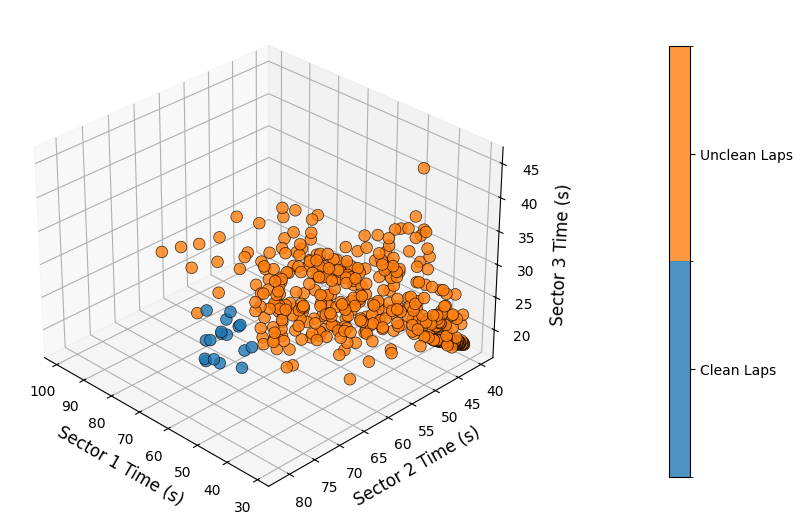

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np

features = ['Sector1Time', 'Sector2Time', 'Sector3Time']

def cluster0_quality_score(X_scaled, labels):
    cluster0_points = X_scaled[labels == 0]
    other_points = X_scaled[labels != 0]

    if len(cluster0_points) < 2:
        return -1  # Not enough points in cluster 0

    # Intra-cluster distances within cluster 0 (pairwise)
    intra_dists = cdist(cluster0_points, cluster0_points, metric='chebyshev')
    intra_dists = intra_dists[np.triu_indices_from(intra_dists, k=1)]
    mean_intra = np.mean(intra_dists)

    if len(other_points) == 0:
        return mean_intra  # No separation possible

    # Inter-cluster distances between cluster 0 and others
    inter_dists = cdist(cluster0_points, other_points, metric='chebyshev')
    mean_inter = np.mean(inter_dists)

    # Higher separation/compactness ratio is better
    return mean_inter / (mean_intra + 1e-10)

def tune_KMeans(features, data, max_clusters=10):
    data_clean = data[~data['InLap'] & ~data['OutLap']].dropna(subset=features)
    X = data_clean[features].astype(float).values
    X_scaled = StandardScaler().fit_transform(X)

    results = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)

        # Use cluster0 quality score instead of silhouette
        score = cluster0_quality_score(X_scaled, labels)

        results.append({
            'n_clusters': k,
            'cluster0_score': score,
            'inertia': kmeans.inertia_
        })

    results_df = pd.DataFrame(results)
    best = results_df.loc[results_df['cluster0_score'].idxmax()]
    print("Best Params according to cluster0 quality score:")
    print(best)
    return best

def perform_kmeans(params, data, features, column_name='KMeansCluster'):
    data_clean = data[~data['InLap'] & ~data['OutLap']].dropna(subset=features)
    n_clusters = int(params['n_clusters'])

    X = data_clean[features].astype(float).values
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    data.loc[data_clean.index, column_name] = clusters
    print(data[column_name].value_counts())

    return data


best_kmeans = tune_KMeans(features, data)
data = perform_kmeans(best_kmeans, data, features)

print_graph(data, 'KMeansCluster')

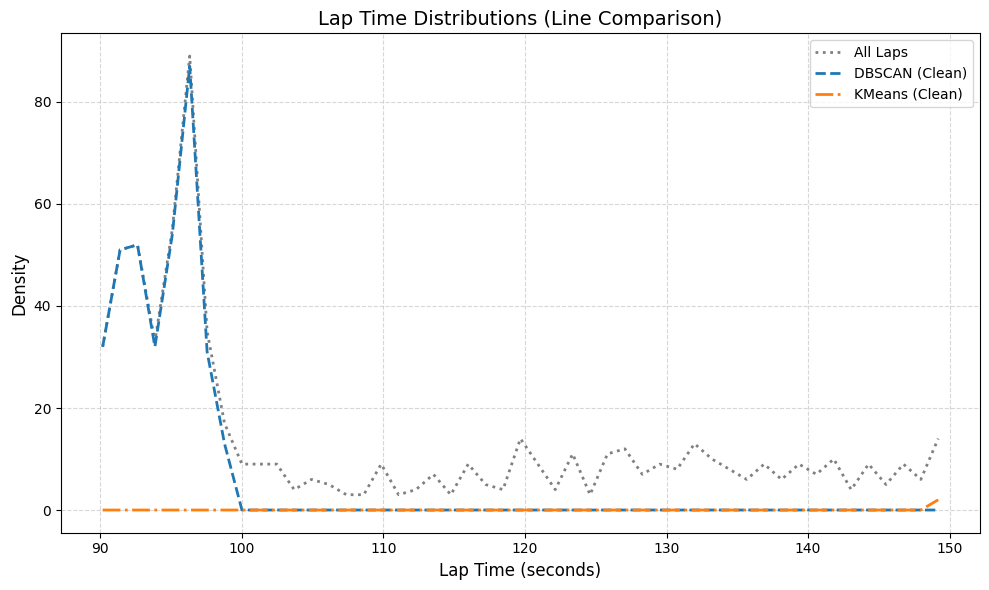

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define the clean label
CLEAN = 0

# Extract LapTimes in seconds
laptimes_all = data['LapTime'].dt.total_seconds().dropna()
laptimes_dbscan = data[data['Cluster'] == CLEAN]['LapTime'].dt.total_seconds()
laptimes_kmeans = data[data['KMeansCluster'] == CLEAN]['LapTime'].dt.total_seconds()

# Define common bin edges
min_time = min(laptimes_all.min(), laptimes_dbscan.min(), laptimes_kmeans.min())
max_time = max(laptimes_all.max(), laptimes_dbscan.max(), laptimes_kmeans.max())
bins = np.linspace(min_time, max_time, 50)

# Compute histograms (density=True for shape comparison)
hist_all, _ = np.histogram(laptimes_all, bins=bins, density=False)
hist_dbscan, _ = np.histogram(laptimes_dbscan, bins=bins, density=False)
hist_kmeans, _ = np.histogram(laptimes_kmeans, bins=bins, density=False)

# Use bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(bin_centers, hist_all, linestyle=':', label='All Laps', color='gray', linewidth=2)
plt.plot(bin_centers, hist_dbscan, linestyle='--', label='DBSCAN (Clean)', color='tab:blue', linewidth=2)
plt.plot(bin_centers, hist_kmeans, linestyle='-.', label='KMeans (Clean)', color='tab:orange', linewidth=2)

# Formatting
plt.title('Lap Time Distributions (Line Comparison)', fontsize=14)
plt.xlabel('Lap Time (seconds)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [10]:
print(data[data['Cluster'] == 0]['LapTime'].count())

print(data[data['KMeansCluster'] == 0]['LapTime'].count())

data = data[data['Cluster'] == 0]

352
2


I due clustering danno risultati molto simili, preferisco intanto quello di KMeans e poi faremo un ulteriore clustering per capire quali giri hanno avuto pochi errori da parte del pilota e quali invece hanno mostrato errori maggiori

Dopo il primo clustering ottenuto con K-means, calcolo ora la varianza nei tempi dei vari settori (standardizzati per dare loro la stessa importanza). In questo modo possiamo distinguere i giri in cui il pilota ha commesso gravi errori da quelli puliti

In [11]:
from sklearn.preprocessing import StandardScaler

def compute_sector_variance(data):
    # Ensure required columns are present
    required_cols = ['Sector1Time', 'Sector2Time', 'Sector3Time']
    if not all(col in data.columns for col in required_cols):
        raise ValueError(f"Missing one of the required columns: {required_cols}")

    # Drop rows with NaNs in sector times
    data = data.dropna(subset=required_cols).copy()

    # Extract sector times
    sectors = data[required_cols].values

    # Standardize sector times (mean=0, std=1)
    scaler = StandardScaler()
    standardized_sectors = scaler.fit_transform(sectors)

    # Get standardized values for each sector
    s1_std = standardized_sectors[:, 0]
    s2_std = standardized_sectors[:, 1]
    s3_std = standardized_sectors[:, 2]

    # Compute average delta from theoretical best time (which now is also standardized)
    avg = (s1_std + s2_std + s3_std) / 3

    # Compute variance based on standardized times
    data['SectorVariance'] = (
        (s1_std - avg) ** 2 +
        (s2_std - avg) ** 2 +
        (s3_std - avg) ** 2
    )
    return data

data = compute_sector_variance(data)

Number of laps with low variance: 312


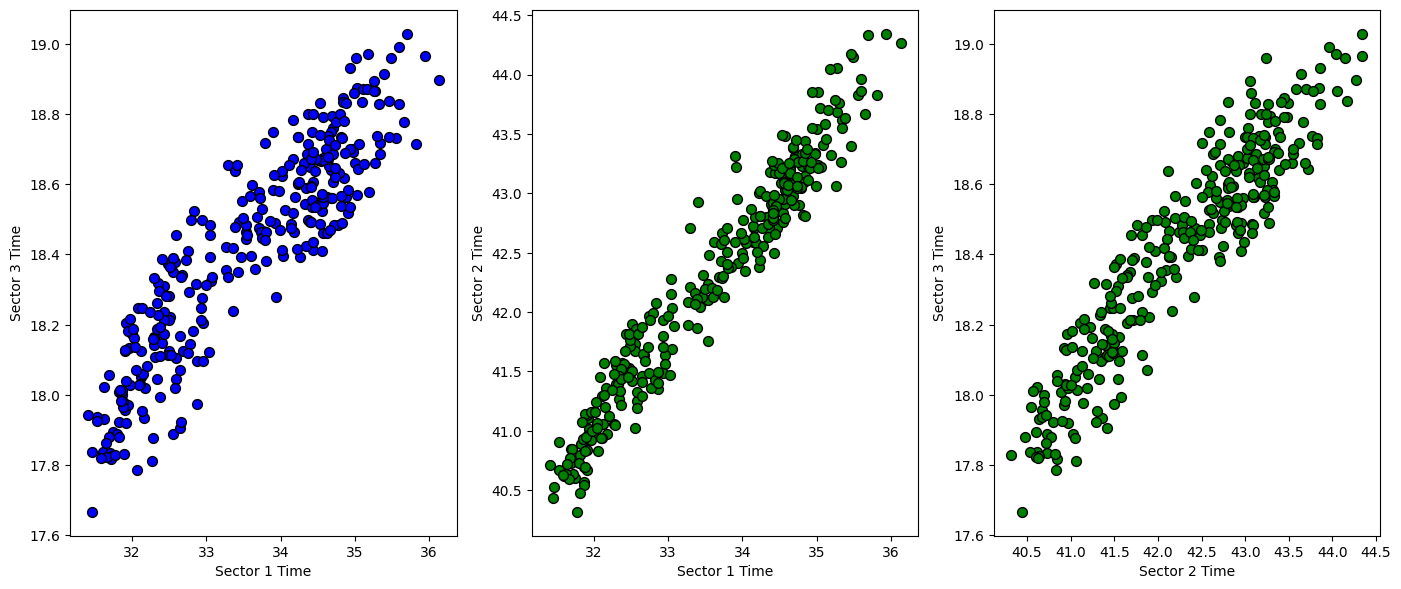

In [12]:
import matplotlib.pyplot as plt

soglia = 0.5  # Threshold for low variance

low_variance_data = data[data['SectorVariance'] < soglia]

print(f"Number of laps with low variance: {len(low_variance_data)}")

fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Plot Sector1Time vs Sector3Time
axes[0].scatter(low_variance_data['Sector1Time'], low_variance_data['Sector3Time'], c='blue', edgecolor='k', s=50)
axes[0].set_xlabel('Sector 1 Time')
axes[0].set_ylabel('Sector 3 Time')

# Plot Sector1Time vs Sector2Time
axes[1].scatter(low_variance_data['Sector1Time'], low_variance_data['Sector2Time'], c='green', edgecolor='k', s=50)
axes[1].set_xlabel('Sector 1 Time')
axes[1].set_ylabel('Sector 2 Time')

# Plot Sector1Time vs Sector2Time
axes[2].scatter(low_variance_data['Sector2Time'], low_variance_data['Sector3Time'], c='green', edgecolor='k', s=50)
axes[2].set_xlabel('Sector 2 Time')
axes[2].set_ylabel('Sector 3 Time')

plt.tight_layout()
plt.show()


In [13]:
print(low_variance_data.columns)

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'LapsInStint', 'OutLap', 'InLap',
       'FuelLevel', 'Session', 'Cluster', 'KMeansCluster', 'SectorVariance'],
      dtype='object')


In [14]:
summary = low_variance_data.groupby(['Compound', 'TyreLife']).agg({
    'SectorVariance': 'mean',
    'Sector1Time': 'mean',
    'Sector2Time': 'mean',
    'Sector3Time': 'mean',
    'LapTime': 'mean',
    'FuelLevel': 'mean',
    'LapNumber': 'count'
}).rename(columns={'LapNumber': 'LapCount'})

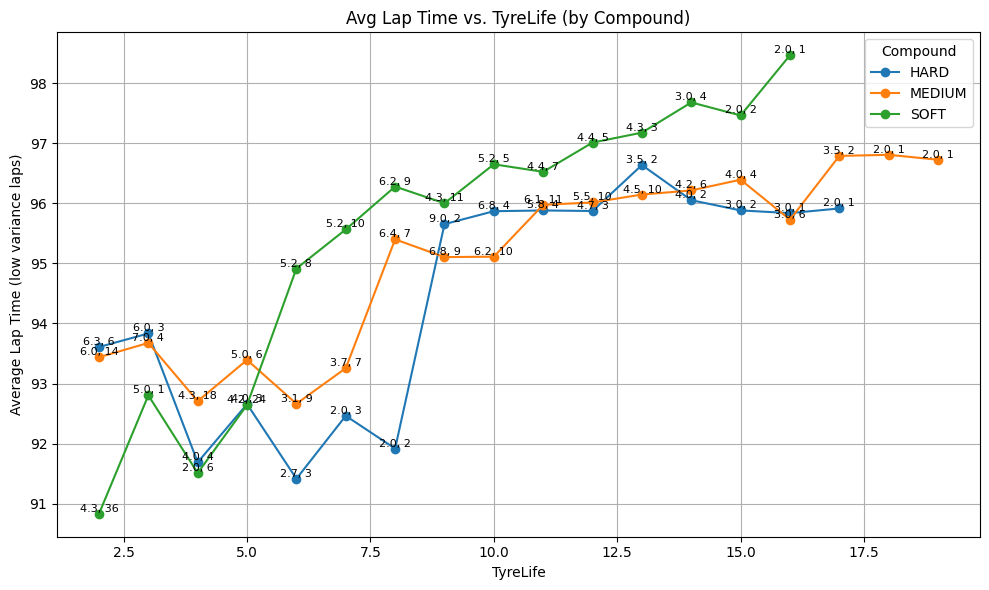

In [15]:
import matplotlib.pyplot as plt

# Reset index so Compound and TyreLife become columns
summary_reset = summary.reset_index()
summary_reset['LapTimeSeconds'] = summary_reset['LapTime'].dt.total_seconds()

# Plot
plt.figure(figsize=(10, 6))

for compound in summary_reset['Compound'].unique():
    compound_data = summary_reset[summary_reset['Compound'] == compound]
    compound_data = compound_data.sort_values('TyreLife')  # optional sorting

    plt.plot(
        compound_data['TyreLife'],
        compound_data['LapTimeSeconds'],
        marker='o',
        label=compound
    )

    # Add LapCount labels
    for _, row in compound_data.iterrows():
        plt.text(
            row['TyreLife'],
            row['LapTimeSeconds'],
            f"{row['FuelLevel']:.1f}, {row['LapCount']}",
            fontsize=8,
            ha='center',
            va='bottom'
        )

plt.xlabel('TyreLife')
plt.ylabel('Average Lap Time (low variance laps)')
plt.title('Avg Lap Time vs. TyreLife (by Compound)')
plt.legend(title='Compound')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\marti\AppData\Local\Temp\ipykernel_7432\171956857.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_variance_data['LapTimeSeconds'] = low_variance_data['LapTime'].dt.total_seconds().round(2)


Fitting 5 folds for each of 3200 candidates, totalling 16000 fits
Best Parameters: {'regressor__ccp_alpha': 0.0, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10}
Test MSE: 1.68
Test MAE: 1.00


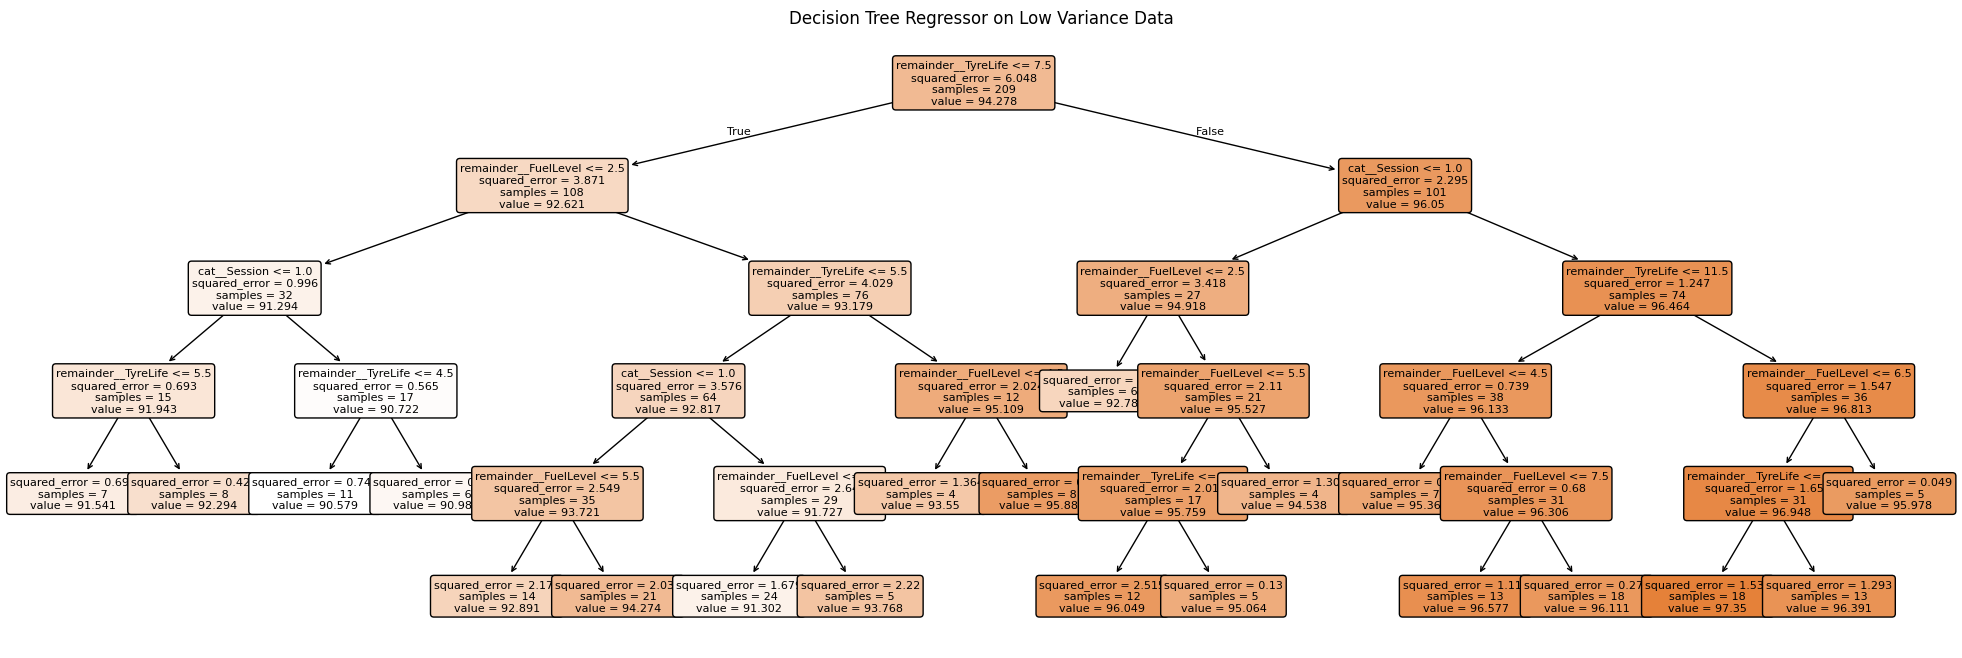

C:\Users\marti\AppData\Local\Temp\ipykernel_7432\171956857.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_variance_data['DecisionTreeLapTime'] = best_model.predict(X)


In [16]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

low_variance_data['LapTimeSeconds'] = low_variance_data['LapTime'].dt.total_seconds().round(2)

# Step 2: Define features and target
X = low_variance_data[['Compound', 'TyreLife', 'FuelLevel', 'Session']]
y = low_variance_data['LapTimeSeconds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define hyperparameter grid
param_grid = {
    'regressor__max_depth': [4, 5, 6, 7, 8, 9, 10, None],
    'regressor__min_samples_split': [6, 7,8,9, 10, 11, 12, 13, 14, 15],
    'regressor__min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10],
    'regressor__ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.02]
}


# we use an ordinal encoder also for session because we consider the track evolution

# idea: use an encoder that gives value basing on how much usually the track improves
categorical_features = ['Compound', 'Session']
preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1,
        categories=[
            ['Hard', 'Medium', 'Soft'],  # for Compound
            ['FP1', 'FP2', 'FP3', 'Race', 'Q']  # for Session
        ]
    ), categorical_features)
], remainder='passthrough')


# Pipeline: preprocessing + regressor
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=0))
])

# Set up grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Optional: evaluate
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.2f}")



# Step 6: Plot the decision tree
plt.figure(figsize=(25, 8))
plot_tree(
    best_model.named_steps['regressor'],
    feature_names=best_model.named_steps['preprocessing'].get_feature_names_out(),
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree Regressor on Low Variance Data")
plt.show()

low_variance_data['DecisionTreeLapTime'] = best_model.predict(X)

In [17]:
print(low_variance_data[['DecisionTreeLapTime', 'LapTimeSeconds', 'Compound', 'TyreLife', 'FuelLevel', 'Session']])

     DecisionTreeLapTime  LapTimeSeconds Compound  TyreLife  FuelLevel Session
2              94.274286           92.64     HARD       3.0        6.0     FP1
4              92.890714           91.95     HARD       5.0        4.0     FP1
6              92.293750           91.46     HARD       7.0        2.0     FP1
9              91.541429           90.06     SOFT       2.0        2.0     FP1
12             94.537500           96.50     HARD      10.0        6.0     FP1
..                   ...             ...      ...       ...        ...     ...
878            96.576923           96.51     SOFT       8.0        6.0     FP3
879            96.576923           96.93     SOFT       9.0        5.0     FP3
881            95.364286           97.73     SOFT      11.0        3.0     FP3
882            97.350000           97.90     SOFT      12.0        2.0     FP3
885            90.579091           90.23     SOFT       2.0        2.0     FP3

[312 rows x 6 columns]


In [18]:
test_set = pd.DataFrame(X_test, columns=['Compound', 'TyreLife', 'FuelLevel'])
test_set['DecisionTreeLapTime'] = best_model.predict(X_test)
test_set['LapTimeSeconds'] = y_test.values

print(test_set)

    Compound  TyreLife  FuelLevel  DecisionTreeLapTime  LapTimeSeconds
707   MEDIUM      12.0        3.0            97.350000           95.66
21    MEDIUM       4.0        2.0            91.541429           94.34
178     SOFT       7.0        2.0            92.293750           92.62
188   MEDIUM       6.0        2.0            92.293750           92.66
74      SOFT       7.0        5.0            95.888750           96.85
..       ...       ...        ...                  ...             ...
44      HARD       4.0        2.0            91.541429           91.81
26    MEDIUM       9.0        2.0            92.788333           93.13
567   MEDIUM      13.0        5.0            97.350000           96.51
519     SOFT       6.0        3.0            93.550000           92.18
300     SOFT      11.0        2.0            92.788333           97.75

[103 rows x 5 columns]


In [19]:
print(f"Mean Squared Error on test set: {mean_squared_error(test_set['DecisionTreeLapTime'], test_set['LapTimeSeconds'])}")
print(f"Mean Squared Error on training set: {mean_squared_error(low_variance_data['DecisionTreeLapTime'], low_variance_data['LapTimeSeconds'])}")

Mean Squared Error on test set: 1.6752414243922895
Mean Squared Error on training set: 1.4074415296445233


Risultati più che accettabili visto che non stiamo considerando il pilota

In [20]:
low_variance_data.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'LapsInStint', 'OutLap', 'InLap',
       'FuelLevel', 'Session', 'Cluster', 'KMeansCluster', 'SectorVariance',
       'LapTimeSeconds', 'DecisionTreeLapTime'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# ------------------------------
# SETTINGS
# ------------------------------
predictors = ['Compound', 'TyreLife', 'FuelLevel', 'Session']
target = 'LapTimeSeconds'

# Prepare input (X) and target (y)
X = low_variance_data[predictors].values
y = low_variance_data[target].values

# Identify categorical columns
categorical_cols = ['Compound', 'Session']
categorical_idx = [predictors.index(col) for col in categorical_cols]

# One-hot encode categorical columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_data = X[:, categorical_idx]
categorical_encoded = ohe.fit_transform(categorical_data)

# Keep numeric columns
numeric_data = np.delete(X, categorical_idx, axis=1)

# Combine encoded categorical data with numeric data
X = np.hstack((categorical_encoded, numeric_data)).astype(float)

# ------------------------------
# TRAIN-TEST SPLIT
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------
# BUILD NEURAL NETWORK
# ------------------------------
model = Sequential([
    Dense(6, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(3, activation='relu'),
    Dense(1)  # Output for regression
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# ------------------------------
# TRAIN MODEL
# ------------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=35,
    verbose=1
)

# ------------------------------
# EVALUATE MODEL
# ------------------------------
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MSE: {test_mse:.2f}")

# ------------------------------
# PREDICT
# ------------------------------
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test set: {mse}")

# Mean squared error on training set
y_train_pred = model.predict(X_train)
print(f"Mean Squared Error on training set: {mean_squared_error(y_train, y_train_pred)}")


c:\Users\marti\Desktop\programmazione\F1\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 8885.3828 - mse: 8885.3828 - val_loss: 8805.7002 - val_mse: 8805.7002
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8858.5439 - mse: 8858.5439 - val_loss: 8787.3184 - val_mse: 8787.3184
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8803.6377 - mse: 8803.6377 - val_loss: 8767.5928 - val_mse: 8767.5928
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8808.4902 - mse: 8808.4902 - val_loss: 8745.9717 - val_mse: 8745.9717
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8763.2656 - mse: 8763.2656 - val_loss: 8721.7588 - val_mse: 8721.7588
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8727.7988 - mse: 8727.7988 - val_loss: 8694.2939 - val_mse: 8694.2939
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 8715.9814 - mse: 8715.9814 - val_loss: 8662.8408 - val_mse: 8662.8408
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8695.7461 - mse: 8695.7461 - val_loss

Mean Squared Error on test set: 2.6039005205699044
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared Error on training set: 2.1665687660965345


We use session as predictor since we expect an imrpovment trought the session.

In [23]:
grouped_avg = low_variance_data.groupby(['Session', 'Compound']).mean(numeric_only=True).reset_index()
print(grouped_avg[['LapTimeSeconds', 'Session', 'Compound', 'TyreLife', 'FuelLevel']])


   LapTimeSeconds Session Compound   TyreLife  FuelLevel
0       93.929200     FP1     HARD   6.480000   4.320000
1       93.518182     FP1   MEDIUM   6.818182   4.418182
2       93.992449     FP1     SOFT   5.448980   4.183673
3       94.496500     FP3     HARD  10.000000   5.100000
4       95.395125     FP3   MEDIUM   9.862500   5.437500
5       93.814940     FP3     SOFT   6.855422   4.493976


Sistemare i tempi in base alla sessione modificando l'encoding, aggiungo a decision tree e alla rete neurale.

Dare un valore ordinato a gomme e sessione in base alla teoria.

E spingo con la rete neurale.

Faccio un test sui tempi in gara.

Sistemo clustering.

rete neurale che sfrutta anche le predizioni e i risultati delle gare precedenti